the number of lisposomes for s7 is :
66
the number of lisposomes for s8 is :
66
the number of lisposomes for s9 is :
66
the number of lisposomes for s7 is :
66
the number of lisposomes for s8 is :
66
the number of lisposomes for s9 is :
66


/Users/Maczang/.pyenv/versions/3.7.7/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


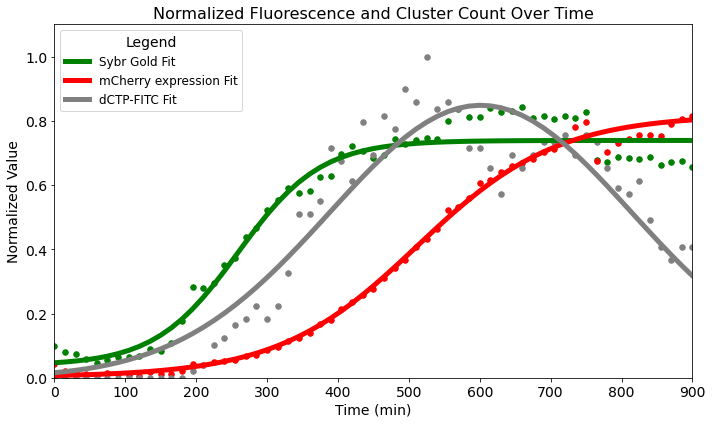

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the Excel file names
file_names = ["data_PC.xlsx"]
labels = ["Sybr Gold", "mCherry expression"]

# File paths for the replicates (for histogram data)
file_paths = [
    'Results9.csv',
    'Results10.csv',
    'Results19.csv',
    'Results20.csv'
]

# Define sigmoid function for curve fitting
def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

# Define Gaussian function for histogram fitting
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

# Function to process fluorescence data
def process_data(file_name, fluorophore='GFP'):
    # Load the Excel file
    xls = pd.ExcelFile(file_name)
    normalized_data = []

    for sheet_name in xls.sheet_names:
        # Read each sheet
        df = xls.parse(sheet_name)
        time = df['Time [min]']
        fluor_columns = [col for col in df.columns if fluorophore in col]
        fluorescence_data = df[fluor_columns]
        #print(fluorescence_data)
        print('the number of lisposomes for', sheet_name, 'is :')
        print(len(fluorescence_data))

        # Min/Max normalization
        normalized_fluorescence = (fluorescence_data - fluorescence_data.min()) / (fluorescence_data.max() - fluorescence_data.min())
        normalized_data.append(normalized_fluorescence)

    # Combine replicates and compute mean and std
    combined_data = pd.concat(normalized_data, axis=1)
    mean_fluorescence = combined_data.mean(axis=1)
    std_fluorescence = combined_data.std(axis=1)
    return time, mean_fluorescence, std_fluorescence

# Histogram processing
data_frames = []
for idx, file_path in enumerate(file_paths):
    df = pd.read_csv(file_path)
    df['Replicate'] = f'Replicate {idx + 1}'
    data_frames.append(df)

combined_data = pd.concat(data_frames, ignore_index=True)
grouped = combined_data.groupby(['Slice', 'Replicate']).size().unstack(fill_value=0)

# Handle missing time points by padding with zeros
L = 63 - len(grouped)
timepoints_added = [k for k in range(L + 1)]
replicate_added = [0 for k in range(L + 1)]
data_added = {'Slice': timepoints_added, 'Replicate 1': replicate_added, 'Replicate 2': replicate_added,
              'Replicate 3': replicate_added, 'Replicate 4': replicate_added}
df_added = pd.DataFrame(data_added).set_index('Slice')
grouped_padded = pd.concat([df_added, grouped], ignore_index=False)
grouped_padded['sum'] = grouped_padded.sum(axis=1)
histo_normalized = (grouped_padded['sum'] - grouped_padded['sum'].min()) / (grouped_padded['sum'].max() - grouped_padded['sum'].min())
time3 = grouped_padded.index * 15
histo = histo_normalized

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Process fluorescence data and plot
for i, file_name in enumerate(file_names):
    # Process fluorescence data for Sybr Gold and mCherry
    time, mean_fluorescence, _ = process_data(file_name, fluorophore='GFP')
    time2, mean_fluorescence2, _ = process_data(file_name, fluorophore='TexRed')

    # Fit sigmoid curves
    p0 = [1, np.median(time), 1, 0]  # Initial guess for Sybr Gold
    p02 = [1, np.median(time2), 1, 0]  # Initial guess for mCherry
    popt, _ = curve_fit(sigmoid, time, mean_fluorescence, p0, method='lm')
    popt2, _ = curve_fit(sigmoid, time2, mean_fluorescence2, p02, method='lm')

    # Generate fitted curves
    y = sigmoid(time, *popt)
    y2 = sigmoid(time2, *popt2)
    L, t0, k, b = popt
    L2, t02, k2, b2 = popt2

    # Plot normalized sigmoid fits and mean fluorescence points
    ax.plot(time, y, label=f'{labels[0]} Fit', color='green', linewidth=5)
    ax.plot(time2, y2, label=f'{labels[1]} Fit', color='red', linewidth=5)
    ax.scatter(time, mean_fluorescence, color='green', s=30)
    ax.scatter(time2, mean_fluorescence2, color='red', s=30)


# Fit Gaussian to histogram
popt_gauss, _ = curve_fit(gaussian, time3, histo, p0=[1, np.mean(time3), 50])
gauss_fit = gaussian(time3, *popt_gauss)
amplitude, peak_gaussian, stddev = popt_gauss

# Find start of histogram
start_histogram = time3[next(i for i, v in enumerate(histo) if v > 0)]

# Plot histogram Gaussian fit and bar plot
ax.plot(time3, gauss_fit, color='gray', linewidth=5, label='dCTP-FITC Fit')
#ax.bar(time3, histo, width=15, color='lightgray', alpha=0.7, label='Histogram Data')
ax.scatter(time3, histo, color='gray', s=30)

# Add vertical lines for histogram characteristic points
#ax.axvline(x=start_histogram, color='purple', linestyle='--', label=f'Histogram Start ({start_histogram:.2f} min)')
#ax.axvline(x=peak_gaussian, color='orange', linestyle='--', label=f'Gaussian Peak ({peak_gaussian:.2f} min)')

# Customize plot
ax.set_xlim(0, 900)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Time (min)', fontsize=14)
ax.set_ylabel('Normalized Value', fontsize=14)
ax.set_title('Normalized Fluorescence and Cluster Count Over Time', fontsize=16)
ax.legend(title='Legend', fontsize=12, title_fontsize=14)
#ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.tick_params(axis='both', labelsize=14)

plt.tight_layout()
#plt.savefig("SI-kinetics.svg", format='svg')
plt.show()
